In [1]:
import torch
from torch import nn, optim
from tqdm import tqdm
import os
import tifffile as tiff
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import random
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
import time
from copy import deepcopy
from sklearn.metrics import accuracy_score

We use the output of projection head because output of botteleneck is 1834 which is greater than 96 input image size. and we can't change the size because then we have to change the model weights then its no meaning to use pretrained model.
strange: i got acc:40% with projection head and without:100%

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
set_seed(42)

In [4]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Custom Dataset class for 3 channel/image
class ImageDataset(Dataset):
    def __init__(self, image_dir,size):
        self.image_dir = image_dir
        #self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
        self.transform = transforms.Compose([
            #transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=size),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
            #transforms.RandomGrayscale(p=0.2),
            #transforms.GaussianBlur(kernel_size=9),
        ])
    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2

# 1 channel
class ImageDataset(Dataset):
    def __init__(self, image_dir, size, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        self.resize_transform = transforms.Resize((size,size))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)
        

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        img1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        img2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        #anchor = self.resize_transform(anchor)
        img1 = self.resize_transform(img1)
        img2 = self.resize_transform(img2)
        
        return img1, img2

In [6]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Plot Top-5 accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Position of Positive Example
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Position')
    plt.title('Training and Validation Mean Position of Positive Example')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()



# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])


# 1 channel
class Resnet(nn.Module):
    def __init__(self, hidden_dim):
        super(Resnet, self).__init__()
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel images
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def forward(self, x):
        return self.convnet(x)

# 1 channel

class Resnet(nn.Module):
    def __init__(self, hidden_dim):
        super(Resnet, self).__init__()
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel images
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def forward(self, x):
        # Forward pass through the ResNet layers
        x = self.convnet.conv1(x)
        x = self.convnet.bn1(x)
        x = self.convnet.relu(x)
        x = self.convnet.maxpool(x)
        print(f"Shape after conv1: {x.shape}")

        x = self.convnet.layer1(x)
        print(f"Shape after layer1: {x.shape}")

        x = self.convnet.layer2(x)
        print(f"Shape after layer2: {x.shape}")

        x = self.convnet.layer3(x)
        print(f"Shape after layer3: {x.shape}")

        x = self.convnet.layer4(x)
        print(f"Shape after layer4: {x.shape}")

        # Global average pooling
        x = self.convnet.avgpool(x)
        print(f"Shape after avgpool: {x.shape}")

        # Flatten the tensor
        x = torch.flatten(x, 1)
        print(f"Shape after flatten: {x.shape}")

        # Pass through the projection head
        x = self.convnet.fc(x)
        print(f"Shape after projection head: {x.shape}")

        return x


# Model for 3 channel/image
class Resnet(nn.Module):
    def __init__(self, hidden_dim):
        super(Resnet, self).__init__()
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def forward(self, x):
        # Pass through the convolutional layers
        x = self.convnet.conv1(x)
        x = self.convnet.bn1(x)
        x = self.convnet.relu(x)
        x = self.convnet.maxpool(x)

        x = self.convnet.layer1(x)
        x = self.convnet.layer2(x)
        x = self.convnet.layer3(x)
        x = self.convnet.layer4(x)

        # Print the shape after each layer
        print(f"Shape after conv1: {x.shape}")
        print(f"Shape after layer1: {x.shape}")
        print(f"Shape after layer2: {x.shape}")
        print(f"Shape after layer3: {x.shape}")
        print(f"Shape after layer4: {x.shape}")

        # Global average pooling
        x = self.convnet.avgpool(x)
        x = torch.flatten(x, 1)
        print(f"Shape after avgpool: {x.shape}")

        # Pass through the projection head
        x = self.convnet.fc(x)
        print(f"Shape after projection head: {x.shape}")

        return x


# 3 channel
class Resnet(nn.Module):
    def __init__(self, hidden_dim):
        super(Resnet, self).__init__()
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')   #weights='ResNet18_Weights.DEFAULT' or weights=None

        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def forward(self, x):
        return self.convnet(x)

In [7]:
# Load the pretrained UNet model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                       in_channels=3, out_channels=1, init_features=32, pretrained=True)

class UNetEncoder(nn.Module):
    def __init__(self, unet_model, image_size=256, in_channel=3,hidden_dim=20):
        super(UNetEncoder, self).__init__()
        self.image_size = image_size
        self.in_channel = in_channel
        self.hidden_dim = hidden_dim
        
        original_encoder1 = unet_model.encoder1
        
        # Create a new encoder1 layer with variable input channels, keeping the same output channels and kernel size
        self.encoder1 = nn.Sequential(
            nn.Conv2d(self.in_channel, original_encoder1[0].out_channels, 
                      kernel_size=original_encoder1[0].kernel_size, 
                      stride=original_encoder1[0].stride, 
                      padding=original_encoder1[0].padding),
            original_encoder1[1]  # Keep the rest of the layers (e.g., BatchNorm, ReLU) intact
        )
        
        self.pool1 = unet_model.pool1
        self.encoder2 = unet_model.encoder2
        self.pool2 = unet_model.pool2
        self.encoder3 = unet_model.encoder3
        self.pool3 = unet_model.pool3
        self.encoder4 = unet_model.encoder4
        self.pool4 = unet_model.pool4
        self.bottleneck = unet_model.bottleneck
        dummy = torch.zeros((1, self.in_channel, image_size, image_size))
        out = self.bottleneck(self.pool4(self.encoder4(self.pool3(self.encoder3(self.pool2(self.encoder2(self.pool1(self.encoder1(dummy)))))))))
        shape= torch.flatten(out, start_dim=1).shape[1]
        
        # Define the fully connected layers after the bottleneck
        self.fc = nn.Sequential(
            nn.Linear(shape, 4 * self.hidden_dim),  # Adjust input size based on bottleneck output
            nn.ReLU(inplace=True),
            nn.Linear(4 * self.hidden_dim, self.hidden_dim)  # Output layer with hidden_dim output
        )

    def forward(self, x):
        x = self.encoder1(x)
        x = self.pool1(x)
        x = self.encoder2(x)
        x = self.pool2(x)
        x = self.encoder3(x)
        x = self.pool3(x)
        x = self.encoder4(x)
        x = self.pool4(x)
        bottleneck = self.bottleneck(x)
        
        # Flatten the bottleneck output for the fully connected layer
        bottleneck_flat = torch.flatten(bottleneck, start_dim=1)
        
        # Pass through the fully connected layers
        output = self.fc(bottleneck_flat)
        
        # Return all encoder outputs or just bottleneck, depending on your needs
        return output

Using cache found in C:\Users\k54739/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [8]:
def SimCLR_loss(feats, temperature):
    # Calculate cosine similarity
    cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)
    
    # Find positive example -> batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
    # InfoNCE loss
    cos_sim = cos_sim / temperature
    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()

    # Accuracy calculations
    comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                          cos_sim.masked_fill(pos_mask, -9e15)],
                         dim=-1)
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    # Calculate accuracy metrics
    acc_top1 = (sim_argsort == 0).float().mean()
    acc_top5 = (sim_argsort < 5).float().mean()
    mean_pos = 1 + sim_argsort.float().mean()

    return nll, acc_top1.item(), acc_top5.item(), mean_pos.item()

In [9]:
def train(train_loader, model, epochs, lr=5e-4, temperature=0.07, weight_decay=1e-4, device='cuda', validate=False):
    if not validate:
        model = model.train().to(device)
    else:
        model = model.eval().to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=lr / 50)

    train_losses = []
    train_top1_accs = []
    train_top5_accs = []
    mean_positions = []

    for epoch in range(epochs):
        total_loss = 0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for imgs1, imgs2 in train_loader:
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)
            imgs = torch.cat((imgs1, imgs2), dim=0)
            feats = model(imgs)

            # Compute the loss and accuracy
            loss, acc_top1, acc_top5, mean_pos = SimCLR_loss(feats, temperature)

            if not validate:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            total_loss += loss.item()
            total_top1_acc += acc_top1
            total_top5_acc += acc_top5
            total_mean_pos += mean_pos

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        train_losses.append(avg_loss)
        train_top1_accs.append(avg_top1_acc)
        train_top5_accs.append(avg_top5_acc)
        mean_positions.append(avg_mean_pos)

        print(f"Epoch {epoch + 1}/{epochs} | "
              f"Loss: {avg_loss:.4f} | "
              f"Top-1 Acc: {avg_top1_acc:.2f}% | "
              f"Top-5 Acc: {avg_top5_acc:.2f}% | "
              f"Mean Position: {avg_mean_pos:.2f}")

    return model, (train_losses, train_top1_accs, train_top5_accs, mean_positions)


Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
UNetEncoder(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Sequential(
    (enc3conv1): Conv2d(6

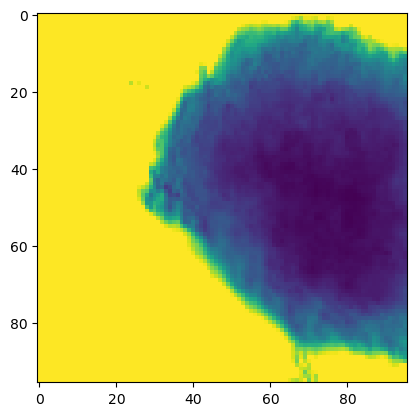

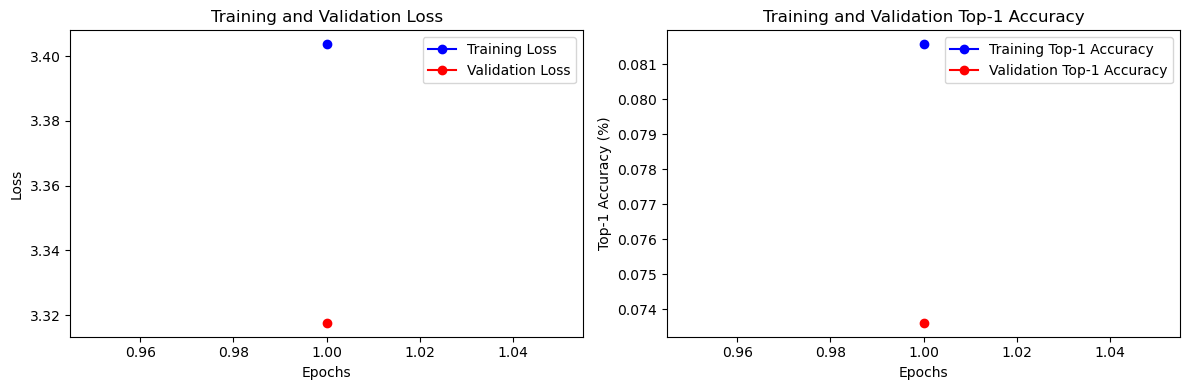

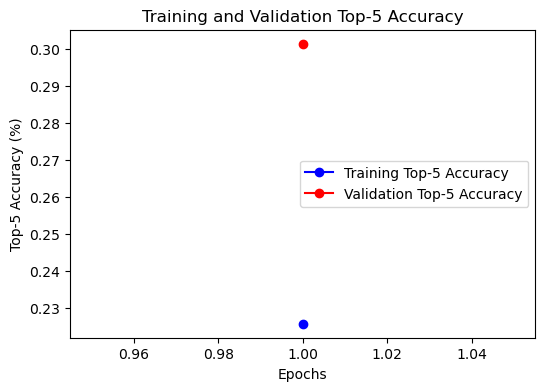

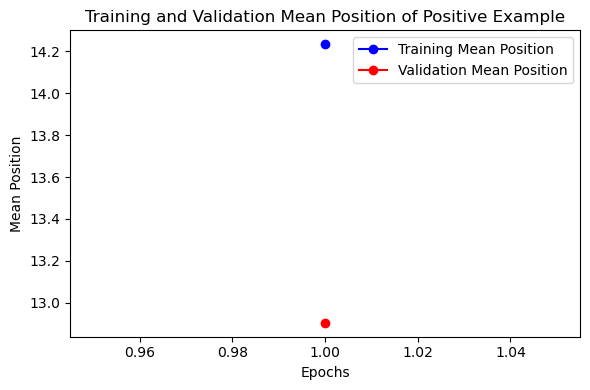

In [10]:
batch_size = 16
size = 96

image_dir = r"../../tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir,size=size)


# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          drop_last=False, 
                          pin_memory=True, 
                          num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        drop_last=False, 
                        pin_memory=True, 
                        num_workers=0)

for i, (image1, image2) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    plt.imshow(image1[0,0])
    break

unet_encoder = UNetEncoder(model,image_size=96,in_channel=3,hidden_dim=20)
#model = Resnet(size)
#print(model)
print(unet_encoder)
print('training')
unet_model, train_results = train(train_loader, unet_encoder, epochs=1, device='cuda')
print('validating')
unet_model, val_results = train(val_loader, unet_encoder, epochs=1, device='cuda', validate=True)

train_losses, train_top1_accs, train_top5_accs, train_mean_pos = train_results
val_losses, val_top1_accs, val_top5_accs, val_mean_pos = val_results

plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos)

### Logistic

In [11]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    classes = ['untreated', 'single_dose', 'drug_screened']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"../../Data_supervised"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [12]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 1, 1, 2, 0])


In [13]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [14]:
# Extract features for train and test datasets
train_feats_unet = prepare_data_features(unet_model, train_loader_labeled)
test_feats_unet = prepare_data_features(unet_model, test_loader_labeled)

 25%|██▌       | 1/4 [00:00<00:02,  1.13it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 50%|█████     | 2/4 [00:01<00:01,  1.13it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 3/4 [00:02<00:00,  1.13it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Batch features shape: torch.Size([9, 20])
Batch labels shape: torch.Size([9])
Features shape after concatenation: torch.Size([57, 20])
Labels shape after concatenation: torch.Size([57])


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

Batch features shape: torch.Size([15, 20])
Batch labels shape: torch.Size([15])
Features shape after concatenation: torch.Size([15, 20])
Labels shape after concatenation: torch.Size([15])


In [15]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [16]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [17]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [18]:
# Main training loop
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0) #num_workers =os.cpu_count()
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_acc = 0.0
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)
        
        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict()

    # Load best model state
    model.load_state_dict(best_model_state)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, {"train_acc": train_acc, "test_acc": test_acc}

Epoch 1/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 543.06it/s]


Training loss: 1.4039, Training accuracy: 0.4211
Test loss: 1.3707, Test accuracy: 0.4000
Epoch 2/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.1648, Training accuracy: 0.4211
Test loss: 1.2830, Test accuracy: 0.4000
Epoch 3/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.97it/s]


Training loss: 1.1197, Training accuracy: 0.4211
Test loss: 1.2335, Test accuracy: 0.4000
Epoch 4/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.74it/s]


Training loss: 1.0948, Training accuracy: 0.4211
Test loss: 1.2095, Test accuracy: 0.4000
Epoch 5/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.72it/s]


Training loss: 1.0788, Training accuracy: 0.4211
Test loss: 1.2079, Test accuracy: 0.4000
Epoch 6/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 152.04it/s]


Training loss: 1.0839, Training accuracy: 0.4211
Test loss: 1.2077, Test accuracy: 0.4000
Epoch 7/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 129.71it/s]


Training loss: 1.2346, Training accuracy: 0.4211
Test loss: 1.2075, Test accuracy: 0.4000
Epoch 8/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 98.94it/s]


Training loss: 1.1411, Training accuracy: 0.4211
Test loss: 1.2072, Test accuracy: 0.4000
Epoch 9/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.1481, Training accuracy: 0.4211
Test loss: 1.2070, Test accuracy: 0.4000
Epoch 10/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.0843, Training accuracy: 0.4211
Test loss: 1.2067, Test accuracy: 0.4000
Epoch 11/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.2645, Training accuracy: 0.4211
Test loss: 1.2065, Test accuracy: 0.4000
Epoch 12/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 117.84it/s]


Training loss: 1.1394, Training accuracy: 0.4211
Test loss: 1.2062, Test accuracy: 0.4000
Epoch 13/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.15it/s]


Training loss: 1.0816, Training accuracy: 0.4211
Test loss: 1.2059, Test accuracy: 0.4000
Epoch 14/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.71it/s]


Training loss: 1.1417, Training accuracy: 0.4211
Test loss: 1.2058, Test accuracy: 0.4000
Epoch 15/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.0816, Training accuracy: 0.4211
Test loss: 1.2055, Test accuracy: 0.4000
Epoch 16/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.50it/s]


Training loss: 1.1501, Training accuracy: 0.4211
Test loss: 1.2053, Test accuracy: 0.4000
Epoch 17/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 107.12it/s]


Training loss: 1.1439, Training accuracy: 0.4211
Test loss: 1.2051, Test accuracy: 0.4000
Epoch 18/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.0841, Training accuracy: 0.4211
Test loss: 1.2049, Test accuracy: 0.4000
Epoch 19/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.1257, Training accuracy: 0.4211
Test loss: 1.2047, Test accuracy: 0.4000
Epoch 20/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.0863, Training accuracy: 0.4211
Test loss: 1.2045, Test accuracy: 0.4000
Epoch 21/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 123.85it/s]


Training loss: 1.1391, Training accuracy: 0.4211
Test loss: 1.2043, Test accuracy: 0.4000
Epoch 22/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 117.96it/s]


Training loss: 1.0823, Training accuracy: 0.4211
Test loss: 1.2041, Test accuracy: 0.4000
Epoch 23/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 106.37it/s]


Training loss: 1.0845, Training accuracy: 0.4211
Test loss: 1.2039, Test accuracy: 0.4000
Epoch 24/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 197.76it/s]


Training loss: 1.1366, Training accuracy: 0.4211
Test loss: 1.2038, Test accuracy: 0.4000
Epoch 25/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.75it/s]


Training loss: 1.2630, Training accuracy: 0.4211
Test loss: 1.2036, Test accuracy: 0.4000
Epoch 26/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.56it/s]


Training loss: 1.0817, Training accuracy: 0.4211
Test loss: 1.2033, Test accuracy: 0.4000
Epoch 27/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.70it/s]


Training loss: 1.1354, Training accuracy: 0.4211
Test loss: 1.2031, Test accuracy: 0.4000
Epoch 28/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 128.10it/s]


Training loss: 1.1234, Training accuracy: 0.4211
Test loss: 1.2029, Test accuracy: 0.4000
Epoch 29/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.2604, Training accuracy: 0.4211
Test loss: 1.2026, Test accuracy: 0.4000
Epoch 30/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.1228, Training accuracy: 0.4211
Test loss: 1.2023, Test accuracy: 0.4000
Epoch 31/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 128.08it/s]


Training loss: 1.2558, Training accuracy: 0.4211
Test loss: 1.2020, Test accuracy: 0.4000
Epoch 32/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 128.00it/s]


Training loss: 1.1362, Training accuracy: 0.4211
Test loss: 1.2017, Test accuracy: 0.4000
Epoch 33/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.92it/s]


Training loss: 1.2598, Training accuracy: 0.4211
Test loss: 1.2015, Test accuracy: 0.4000
Epoch 34/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.0819, Training accuracy: 0.4211
Test loss: 1.2012, Test accuracy: 0.4000
Epoch 35/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.91it/s]


Training loss: 1.0825, Training accuracy: 0.4211
Test loss: 1.2010, Test accuracy: 0.4000
Epoch 36/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.70it/s]


Training loss: 1.0785, Training accuracy: 0.4211
Test loss: 1.2008, Test accuracy: 0.4000
Epoch 37/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.0784, Training accuracy: 0.4211
Test loss: 1.2007, Test accuracy: 0.4000
Epoch 38/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.0708, Training accuracy: 0.4211
Test loss: 1.2007, Test accuracy: 0.4000
Epoch 39/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.2538, Training accuracy: 0.4211
Test loss: 1.2005, Test accuracy: 0.4000
Epoch 40/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.1323, Training accuracy: 0.4211
Test loss: 1.2003, Test accuracy: 0.4000
Epoch 41/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.98it/s]


Training loss: 1.0769, Training accuracy: 0.4211
Test loss: 1.2001, Test accuracy: 0.4000
Epoch 42/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 116.68it/s]


Training loss: 1.2583, Training accuracy: 0.4211
Test loss: 1.1999, Test accuracy: 0.4000
Epoch 43/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 124.08it/s]


Training loss: 1.1320, Training accuracy: 0.4211
Test loss: 1.1996, Test accuracy: 0.4000
Epoch 44/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 117.56it/s]


Training loss: 1.0773, Training accuracy: 0.4211
Test loss: 1.1994, Test accuracy: 0.4000
Epoch 45/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.2574, Training accuracy: 0.4211
Test loss: 1.1992, Test accuracy: 0.4000
Epoch 46/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 120.21it/s]


Training loss: 1.0873, Training accuracy: 0.4211
Test loss: 1.1990, Test accuracy: 0.4000
Epoch 47/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 112.36it/s]


Training loss: 1.0767, Training accuracy: 0.4211
Test loss: 1.1988, Test accuracy: 0.4000
Epoch 48/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 19831.22it/s]


Training loss: 1.1483, Training accuracy: 0.4211
Test loss: 1.1987, Test accuracy: 0.4000
Epoch 49/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 1.0871, Training accuracy: 0.4211
Test loss: 1.1985, Test accuracy: 0.4000
Epoch 50/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.71it/s]


Training loss: 1.0698, Training accuracy: 0.4211
Test loss: 1.1984, Test accuracy: 0.4000


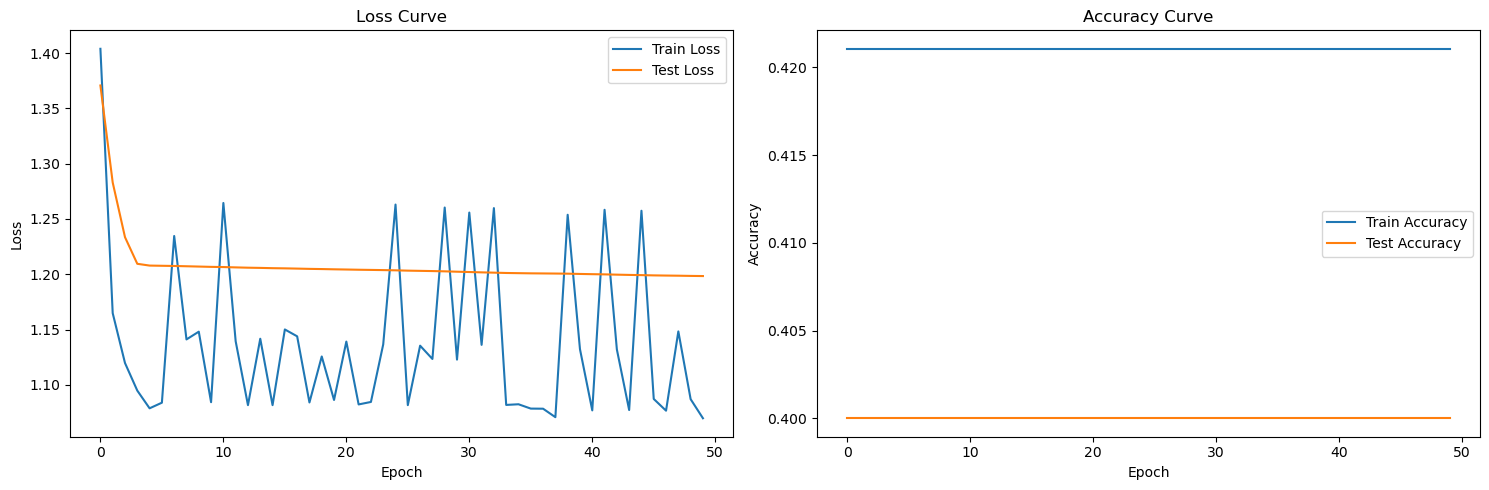

In [19]:
# Train the logistic regression model
logreg_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_unet,
    test_feats_data=test_feats_unet,
    feature_dim=train_feats_unet.tensors[0].shape[1],
    num_classes=3,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=50
)

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")
